# 1. 작업 기본 세팅

## 1.1 Workspace 설정

In [1]:
from azure.quantum import Workspace
workspace = Workspace (
    subscription_id = "put your subscription id here",
    resource_group = "put your resource group here",
    name = "put your workspace name here",
    location = "put your workspace location here"
)


## 1.2 모듈 불러오기

In [10]:
import math
import sympy as sym
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from azure.quantum.optimization import Problem, ProblemType, Term
from typing import List
from azure.quantum.optimization import ParallelTempering, Tabu, SimulatedAnnealing
import time

## 1.3 시간표 설정

In [3]:
TABLE_BIT = 2 # 수업 종류를 나타내는 비트 수
TABLE_WIDTH = 3 # 시간표 가로
TABLE_LENGTH = 2 # 시간표 세로
TABLE_COUNT = 3 # 반의 수(시간표 개수)
CLASS_LIST = {
  'free':2,
  'class1':2,
  'class2':2,
  'none1':0
  # (수업 이름):(수업 횟수)
}
PROBLEM_NAME = f"{TABLE_COUNT}×{TABLE_WIDTH}×{TABLE_LENGTH} SOLVE"

# 2. 식 생성

## 2.1 sympy 변수 생성 및 도움이 되는 함수 정의

In [4]:
# 변수 생성
var_list = []
for i in range(0, TABLE_BIT * TABLE_COUNT * TABLE_LENGTH * TABLE_WIDTH):
  var_list.append(sym.symbols('v' + str(i)))
class_bit_count = math.ceil(math.log(len(CLASS_LIST),2))

# 도움이 되는 함수 정의

def find_variable(table_num, loc, bit):
  return var_list[table_num * TABLE_WIDTH * TABLE_LENGTH * TABLE_BIT + loc * TABLE_BIT + bit]

def num_to_binary_list(num):
  a = list(0 for i in range(TABLE_BIT))
  for i in range(TABLE_BIT):
    a[i] = num % 2
    num = num // 2
  return a

## 2.2 기본 식 생성

In [5]:

poly = sym.sympify("0")

# 겹치는 부분 확인
for i in range(0, TABLE_COUNT):
  for j in range(i+1, TABLE_COUNT):
    for k in range(0, TABLE_WIDTH * TABLE_LENGTH):
      new_poly = sym.sympify("1")
      for m in range(0, TABLE_BIT):
        new_poly *= ((1-find_variable(i, k, m)) * (1-find_variable(j, k, m))+find_variable(i, k, m) * find_variable(j, k, m))
      sum_poly = 0
      for m in range(0, TABLE_BIT):
        sum_poly += (find_variable(i, k, m) + find_variable(j, k, m))
      new_poly *= sum_poly
      poly += new_poly
poly = poly.expand()

# 모든 변수는 0또는 1의 값을 가지기 때문에 거듭제곱은 의미가 없음
# 그거 지우는 부분 코드임
new_poly = str(poly)
new_poly = re.sub('\*\*\d*', '', new_poly)
poly = sym.sympify(new_poly)
poly = poly.simplify()
del new_poly
del sum_poly



# 수업 시수가 맞게 있는지 확인
for i in range(0, TABLE_COUNT):
  for j in range(1, 2**TABLE_BIT):
    new_poly = 0
    class_bit_list = num_to_binary_list(j)
    for k in range(0, TABLE_WIDTH * TABLE_LENGTH):
      sum_poly = 1
      for bit in range(0, TABLE_BIT):
        sum_poly *= ((1-find_variable(i, k, bit))*(1-class_bit_list[bit])+find_variable(i, k, bit) * class_bit_list[bit])
      new_poly += sum_poly
    poly += (new_poly - list(CLASS_LIST.values())[j]) ** 2
    poly = poly.expand()
    poly = poly.simplify()
new_poly = str(poly)
new_poly = re.sub('\*\*\d*', '', new_poly)
poly = sym.sympify(new_poly)
poly = poly.simplify()
del new_poly
del sum_poly
print("result :",poly)

result : 6*v0*v1*v10*v11 - 2*v0*v1*v10 - 2*v0*v1*v11 + 8*v0*v1*v12*v13 - 2*v0*v1*v12 - 2*v0*v1*v13 + 6*v0*v1*v2*v3 - 2*v0*v1*v2 + 8*v0*v1*v24*v25 - 2*v0*v1*v24 - 2*v0*v1*v25 - 2*v0*v1*v3 + 6*v0*v1*v4*v5 - 2*v0*v1*v4 - 2*v0*v1*v5 + 6*v0*v1*v6*v7 - 2*v0*v1*v6 - 2*v0*v1*v7 + 6*v0*v1*v8*v9 - 2*v0*v1*v8 - 2*v0*v1*v9 + 7*v0*v1 - 2*v0*v10*v11 + 2*v0*v10 - 2*v0*v12*v13 + 2*v0*v12 - 2*v0*v2*v3 + 2*v0*v2 - 2*v0*v24*v25 + 2*v0*v24 - 2*v0*v4*v5 + 2*v0*v4 - 2*v0*v6*v7 + 2*v0*v6 - 2*v0*v8*v9 + 2*v0*v8 - 3*v0 - 2*v1*v10*v11 + 2*v1*v11 - 2*v1*v12*v13 + 2*v1*v13 - 2*v1*v2*v3 - 2*v1*v24*v25 + 2*v1*v25 + 2*v1*v3 - 2*v1*v4*v5 + 2*v1*v5 - 2*v1*v6*v7 + 2*v1*v7 - 2*v1*v8*v9 + 2*v1*v9 - 3*v1 + 6*v10*v11*v2*v3 - 2*v10*v11*v2 + 8*v10*v11*v22*v23 - 2*v10*v11*v22 - 2*v10*v11*v23 - 2*v10*v11*v3 + 8*v10*v11*v34*v35 - 2*v10*v11*v34 - 2*v10*v11*v35 + 6*v10*v11*v4*v5 - 2*v10*v11*v4 - 2*v10*v11*v5 + 6*v10*v11*v6*v7 - 2*v10*v11*v6 - 2*v10*v11*v7 + 6*v10*v11*v8*v9 - 2*v10*v11*v8 - 2*v10*v11*v9 + 7*v10*v11 - 2*v10*v2*v3 +

## 2.3 extra poly(페널티항) 추가

# 3. Degree Reduction

In [6]:
def is_Number(x):
  try:
    a = float(x)
    return True
  except:
    return False

qubo_poly = ''
polys_list = str(poly).split(' ')
for i in range(0, len(polys_list),2):
  before = qubo_poly
  if polys_list[i].count('v') > 2:
    # 필요함
    if i != 0:
      if polys_list[i-1] == '-':
        # freedman method
        
        # 원본 식
        var_list.append(sym.Symbol(f'v{len(var_list)}'))
        tmp_poly_list = polys_list[i].split('*')
        if(is_Number(tmp_poly_list[0])):
          qubo_poly += f'+{tmp_poly_list[0]}*{var_list[-1]}*({polys_list[i].count("v")-1}'
          for j in range(1, len(tmp_poly_list)):
            qubo_poly += f'-{tmp_poly_list[j]}'
        else:
          qubo_poly += f'+{var_list[-1]}*({polys_list[i].count("v")-1}'
          for j in range(0, len(tmp_poly_list)):
            qubo_poly += f'-{tmp_poly_list[j]}'
        qubo_poly += ')'
      else:
        # Ishikawa method
        if polys_list[i].count('v') % 2 == 0:
          tmp_poly_list = polys_list[i].split('*')
          k = math.floor((polys_list[i].count('v') - 1) / 2)
          d = len(tmp_poly_list)
          varStart = len(var_list)
          for _ in range(k):
            var_list.append(sym.Symbol(f'v{len(var_list)}'))
          if(is_Number(tmp_poly_list[0])):
            qubo_poly += f'+{tmp_poly_list[0]}*(0'
            for n1 in range(1,d):
              for n2 in range(n1+1, d):
                qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
            for n1 in range(k):
              qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
            for n1 in range(k):
              for n2 in range(d-1):
                qubo_poly += f'-2*{tmp_poly_list[1+n2]}*{var_list[varStart + n1]}'
            qubo_poly += ')'
          else:
            qubo_poly += f'+(0'
            for n1 in range(d):
              for n2 in range(n1+1, d):
                qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
            for n1 in range(k):
              qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
            for n1 in range(k):
              for n2 in range(d):
                qubo_poly += f'-2*{tmp_poly_list[n2]}*{var_list[varStart + n1]}'
            qubo_poly += ')'
        else:
          tmp_poly_list = polys_list[i].split('*')
          k = math.floor((polys_list[i].count('v') - 1) / 2)
          d = len(tmp_poly_list)
          varStart = len(var_list)
          for _ in range(k):
            var_list.append(sym.Symbol(f'v{len(var_list)}'))
          if(is_Number(tmp_poly_list[0])):
            qubo_poly += f'+{tmp_poly_list[0]}*(0'
            for n1 in range(1,d):
              for n2 in range(n1+1, d):
                qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
            for n1 in range(k):
              qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
            for n1 in range(k):
              for n2 in range(d-1):
                qubo_poly += f'-2*{tmp_poly_list[n2]}*{var_list[varStart + n1]}'
            qubo_poly += f'+{var_list[varStart + k]}*(0'
            for n1 in range(d-1):
              qubo_poly += f'+{tmp_poly_list[n1]}'
            qubo_poly += f'-{d-1}+1))'
          else:
            qubo_poly += f'+(0'
            for n1 in range(d):
              for n2 in range(n1+1, d):
                qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
            for n1 in range(k):
              qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
            for n1 in range(k):
              for n2 in range(d):
                qubo_poly += f'-2*{tmp_poly_list[n2]}*{var_list[varStart + n1]}'
            qubo_poly += f'+{var_list[varStart + k]}*(0'
            for n1 in range(d):
              qubo_poly += f'+{tmp_poly_list[n1]}'
            qubo_poly += f'-{d}+1))'
    else:
      # Ishikawa method
      if polys_list[i].count('v') % 2 == 0:
        tmp_poly_list = polys_list[i].split('*')
        k = math.floor((polys_list[i].count('v') - 1) / 2)
        d = len(tmp_poly_list)
        varStart = len(var_list)
        for _ in range(k):
          var_list.append(sym.Symbol(f'v{len(var_list)}'))
        if(is_Number(tmp_poly_list[0])):
          qubo_poly += f'+{tmp_poly_list[0]}*(0'
          for n1 in range(1,d):
            for n2 in range(n1+1, d):
              qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
          for n1 in range(k):
            qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
          for n1 in range(k):
            for n2 in range(d-1):
              qubo_poly += f'-2*{tmp_poly_list[1+n2]}*{var_list[varStart + n1]}'
          qubo_poly += ')'
        else:
          qubo_poly += f'+(0'
          for n1 in range(d):
            for n2 in range(n1+1, d):
              qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
          for n1 in range(k):
            qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
          for n1 in range(k):
            for n2 in range(d):
              qubo_poly += f'-2*{tmp_poly_list[n2]}*{var_list[varStart + n1]}'
          qubo_poly += ')'
      else:
        tmp_poly_list = polys_list[i].split('*')
        k = math.floor((polys_list[i].count('v') - 1) / 2)
        d = len(tmp_poly_list)
        varStart = len(var_list)
        for _ in range(k):
          var_list.append(sym.Symbol(f'v{len(var_list)}'))
        if(is_Number(tmp_poly_list[0])):
          qubo_poly += f'+{tmp_poly_list[0]}*(0'
          for n1 in range(1,d):
            for n2 in range(n1+1, d):
              qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
          for n1 in range(k):
            qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
          for n1 in range(k):
            for n2 in range(d-1):
              qubo_poly += f'-2*{tmp_poly_list[n2]}*{var_list[varStart + n1]}'
          qubo_poly += f'+{var_list[varStart + k]}*(0'
          for n1 in range(d-1):
            qubo_poly += f'+{tmp_poly_list[n1]}'
          qubo_poly += f'-{d-1}+1))'
        else:
          qubo_poly += f'+(0'
          for n1 in range(d):
            for n2 in range(n1+1, d):
              qubo_poly += f'+{tmp_poly_list[n1]}*{tmp_poly_list[n2]}'
          for n1 in range(k):
            qubo_poly += f'+{(n1+1) * 4 - 1}*{var_list[varStart + n1]}'
          for n1 in range(k):
            for n2 in range(d):
              qubo_poly += f'-2*{tmp_poly_list[n2]}*{var_list[varStart + n1]}'
          qubo_poly += f'+{var_list[varStart + k]}*(0'
          for n1 in range(d):
            qubo_poly += f'+{tmp_poly_list[n1]}'
          qubo_poly += f'-{d}+1))'
  else:
    if i != 0:
      qubo_poly += polys_list[i-1]
    qubo_poly += polys_list[i]
qubo_poly = sym.sympify(qubo_poly)
qubo_poly_extended = qubo_poly.expand()
qubo_poly = qubo_poly_extended.simplify()
print("변환한 식 변수의 수 : ", len(var_list))
del qubo_poly_extended
print("변환한 식:",qubo_poly)

변환한 식 변수의 수 :  351
변환한 식: 53*v0*v1 + 8*v0*v10 + 6*v0*v11 + 10*v0*v12 + 8*v0*v13 + 8*v0*v2 + 10*v0*v24 + 8*v0*v25 + 6*v0*v3 - 12*v0*v36 - 2*v0*v37 - 2*v0*v38 - 16*v0*v39 + 8*v0*v4 - 2*v0*v40 - 2*v0*v41 - 12*v0*v42 - 2*v0*v43 - 16*v0*v44 - 2*v0*v45 - 2*v0*v46 - 2*v0*v47 - 12*v0*v48 - 2*v0*v49 + 6*v0*v5 - 2*v0*v50 - 12*v0*v51 - 2*v0*v52 - 2*v0*v53 - 12*v0*v54 - 2*v0*v55 - 2*v0*v56 - 2*v0*v57 - 2*v0*v58 - 2*v0*v59 + 8*v0*v6 - 2*v0*v60 - 2*v0*v61 - 2*v0*v62 - 2*v0*v63 + 6*v0*v7 + 8*v0*v8 + 6*v0*v9 - 3*v0 + 6*v1*v10 + 8*v1*v11 + 8*v1*v12 + 10*v1*v13 + 6*v1*v2 + 8*v1*v24 + 10*v1*v25 + 8*v1*v3 - 12*v1*v36 - 2*v1*v37 - 2*v1*v38 - 16*v1*v39 + 6*v1*v4 - 2*v1*v40 - 2*v1*v41 - 12*v1*v42 - 2*v1*v43 - 16*v1*v44 - 2*v1*v45 - 2*v1*v46 - 2*v1*v47 - 12*v1*v48 - 2*v1*v49 + 8*v1*v5 - 2*v1*v50 - 12*v1*v51 - 2*v1*v52 - 2*v1*v53 - 12*v1*v54 - 2*v1*v55 - 2*v1*v56 + 6*v1*v6 - 2*v1*v64 - 2*v1*v65 - 2*v1*v66 - 2*v1*v67 - 2*v1*v68 - 2*v1*v69 + 8*v1*v7 - 2*v1*v70 + 6*v1*v8 + 8*v1*v9 - 3*v1 + 53*v10*v11 + 8*v10*v2 +

# 4. AZURE QIQ 사용

## 4.1 Problem 정의

In [7]:
terms: List[Term] = []

for i in qubo_poly.args:
  a = str(i).split('*')
  if(a[0].startswith('-v')):
    a.insert(0, '-1')
    a[1] = a[1][1:]
  elif(a[0].startswith('v')):
    a.insert(0, '1')
  if(len(a)==1):
      terms.append(Term(c=int(a[0]), indices=[]))
  elif(len(a)==2):
    terms.append(Term(c=int(a[0]), indices=[int(a[1][1:])]))
  elif(len(a)==3):
    terms.append(Term(c=int(a[0]), indices=[int(a[1][1:]),int(a[2][1:])]))
problem = Problem(name=PROBLEM_NAME, problem_type=ProblemType.pubo, terms=terms)

## 4.2 실행

In [11]:
solver = SimulatedAnnealing(workspace, timeout=100)

# Optimize the problem
print('Submitting problem...')
start = time.time()
result = solver.optimize(problem)
time_elapsed = time.time() - start
print(f'Result in {time_elapsed} seconds: ', result)
print(result['configuration'].values())

Submitting problem...
..............Result in 120.18068432807922 seconds:  {'version': '1.0', 'configuration': {'0': 0, '1': 0, '2': 0, '3': 1, '4': 1, '5': 0, '6': 0, '7': 1, '8': 1, '9': 0, '10': 0, '11': 0, '12': 1, '13': 0, '14': 0, '15': 0, '16': 0, '17': 1, '18': 1, '19': 0, '20': 0, '21': 0, '22': 0, '23': 1, '24': 0, '25': 1, '26': 1, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 1, '34': 1, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0, '49': 0, '50': 0, '51': 0, '52': 0, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0, '58': 0, '59': 0, '60': 0, '61': 0, '62': 0, '63': 0, '64': 0, '65': 0, '66': 0, '67': 0, '68': 0, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0, '78': 0, '79': 0, '80': 0, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 0, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '95': 0, '96': 0, '97': 0, '98': 0, '99': 0

# 5. 시각화

Setting: {'free': 2, 'class1': 2, 'class2': 2, 'none1': 0}


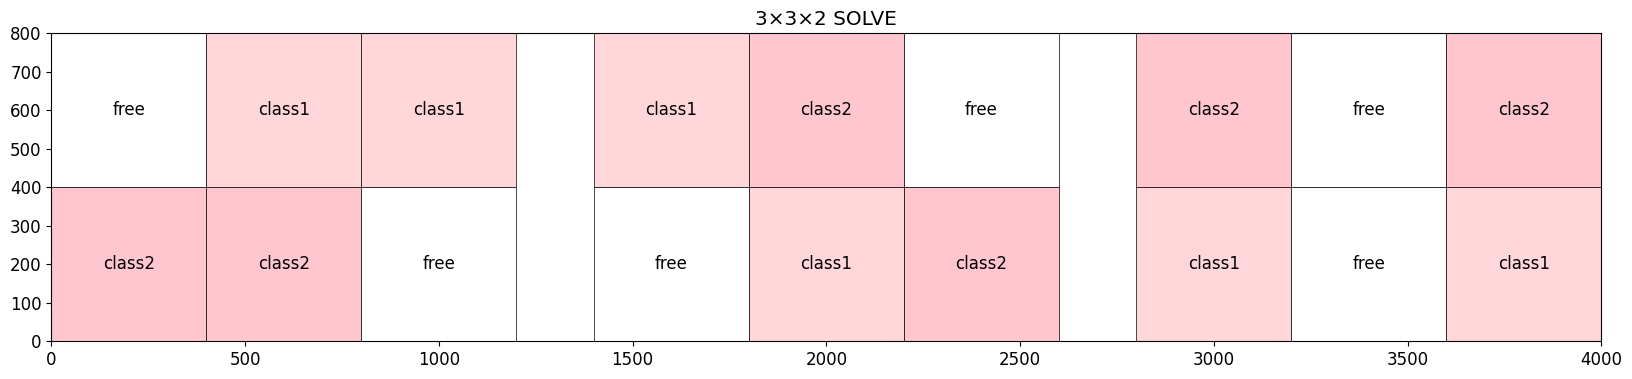

In [12]:
print("Setting:",CLASS_LIST)
data = list(result['configuration'].values())
class_names = list(CLASS_LIST.keys())
rect = []
for i in range(0, TABLE_COUNT):
    for x in range(0, TABLE_WIDTH):
        for y in range(0, TABLE_LENGTH):
            rect.append((x*400+(200+400*TABLE_WIDTH)*i, 400*TABLE_LENGTH-(y+1)*400, 400, 400))

plt.style.use('default')
plt.rcParams['figure.figsize'] = ((TABLE_WIDTH*2+1)*TABLE_COUNT-1, TABLE_LENGTH*2)
plt.rcParams['font.size'] = 12
color = ['white','#FFD6DA', '#FFC6D0', '#E1E7E7','#D1EAF5','#C3D6F2','#789CCE']
count = 0
# 3. add_patch()로 도형 (patches) 시각화하기
fig, ax = plt.subplots()
for (x, y, w, h) in rect:
    sum = 0
    for bit in range(0, TABLE_BIT):
      sum += (2**bit) * data[count*TABLE_BIT + bit]
    ax.add_patch(
        patches.Rectangle(
            (x, y), w, h,
            edgecolor='black',
            facecolor=color[sum],
            linewidth=0.5,
            fill=True))
    plt.annotate(class_names[sum], (x+(w/2), y+(h/2)), ha = 'center', va = 'center')
    count+=1
# 4. 그래프 설정 및 띄우기
ax.set_xlim(0, 200*(TABLE_WIDTH*2+1)*TABLE_COUNT-200)
ax.set_ylim(0, 400*TABLE_LENGTH)
plt.title(PROBLEM_NAME)
plt.show()
plt.close()

# 6. 식 출력

In [13]:
for i in qubo_poly.args:
  a = str(i).split('*')
  if(a[0].startswith('-v')):
    a.insert(0, '-1')
    a[1] = a[1][1:]
  elif(a[0].startswith('v')):
    a.insert(0, '1')
  if(len(a)==1):
      print(f"{a[0]}")
  elif(len(a)==2):
      print(f"{a[0]},{a[1][1:]}")
  elif(len(a)==3):
      print(f"{a[0]},{a[1][1:]},{a[2][1:]}")

24
-3,0
-3,1
-3,10
-3,11
-3,12
-3,13
-3,14
-3,15
-3,16
-3,17
-3,18
-3,19
-3,2
-3,20
-3,21
-3,22
-3,23
-3,24
-3,25
-3,26
-3,27
-3,28
-3,29
-3,3
-3,30
-3,31
-3,32
-3,33
-3,34
-3,35
-3,4
-3,5
-3,6
-3,7
-3,8
-3,9
4,100
4,102
4,103
4,105
4,106
4,108
4,109
4,111
4,112
4,114
4,115
4,117
4,118
4,119
4,120
4,121
4,122
4,123
4,124
4,125
4,126
4,127
4,128
4,129
4,130
4,132
4,133
4,135
4,136
4,138
4,140
4,141
4,143
4,144
4,146
4,147
4,148
4,149
4,150
4,151
4,152
4,153
4,154
4,155
4,156
4,157
4,158
4,159
4,160
4,162
4,163
4,165
4,166
4,168
4,169
4,171
4,172
4,174
4,175
4,176
4,177
4,178
4,179
4,180
4,181
4,182
4,183
4,184
4,185
4,187
4,188
4,190
4,191
4,193
4,194
4,196
4,197
4,198
4,199
4,200
4,201
4,202
4,203
4,204
4,205
4,207
4,208
4,209
4,211
4,212
4,214
4,215
4,217
4,218
4,219
4,220
4,221
4,223
4,224
4,226
4,227
4,229
4,230
4,231
4,232
4,233
4,234
4,235
4,236
4,238
4,239
4,240
4,241
4,243
4,244
4,246
4,247
4,249
4,250
4,252
4,253
4,255
4,256
4,257
4,258
4,259
4,260
4,261
4,262
4,263
4,264
4,265